<a href="https://colab.research.google.com/github/0xbadc0ffe/DeepChaos/blob/main/DeepChaos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
#@title Utilities and Imports

from re import S
from typing import Union, Optional,  Optional, Callable, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import os
import random
import json
import plotly.express as px

#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# reproducibility stuff
if True:
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
    torch.backends.cudnn.benchmark = False


def count_parameters(model: torch.nn.Module) -> int:
  """ Counts the number of trainable parameters of a module
  
  :param model: model that contains the parameters to count
  :returns: the number of parameters in the model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


def lin_sys(x, A, b):
    y = torch.einsum("ik, k -> i", A, x)
    y = y + b
    return y


class ESN(nn.Module):
    def __init__(
        self, Win:torch.Tensor, W:torch.Tensor, activation:str, output_size: int
    ) -> None:
        
        super().__init__()
        #self.fci = nn.Linear(input_size, in_to_hidden)
        self.Win = Win
        self.W = W
        self.activation = activation
        self.ker_size = 10

        if activation == "LeakyReLU":
            self.act = torch.nn.LeakyReLU()
        elif activation == "Tanh":
            self.act = torch.nn.Tanh()
        elif  activation == "ELU":
            self.act = torch.nn.ELU(alpha=1.0, inplace=False)
        elif activation == "ModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "PrModTanh":
            self.mod = nn.Linear(W.shape[0], 1)
            self.act = torch.nn.Tanh()
        elif activation == "ConvModTanh":
            self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(W.shape[0],1))
            self.mod3 = nn.Linear(W.shape[0],1)
            self.act = torch.nn.Tanh()
        else:   
            # Default activation function
            self.act = torch.nn.Tanh()

        self.fco = nn.Linear(W.shape[0], output_size)

        #self.mod2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=self.ker_size)#max(3,W.shape[0]//20))
        #self.mod3 = nn.Linear((W.shape[0]-self.ker_size+1),1)

        #self.mod4 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(W.shape[0],1))
        #self.mod5 = nn.Linear(W.shape[0],1)

    def forward(self, 
                u: torch.Tensor, 
                h_i: torch.Tensor
        ) -> torch.Tensor:

        #x = self.fci(u)
        xu = torch.einsum("ik, k -> i", self.Win, u)
        #x, h_o = self.resvoir(x, h_i)
        x = xu + torch.einsum("ij, j -> i", self.W, h_i)
        #h_o = torch.tanh(x)   # x(n+1) = tanh(Win*u(n) +  W*x(n))
        h_o = self.act(x)

        if self.activation == "ModTanh":
            h_o = (torch.tanh(self.mod(h_o))+1)*h_o  

        elif self.activation == "PrModTanh":
            pr = torch.tanh(torch.einsum("ij, j -> i", self.W, h_o) +  torch.einsum("ik, k -> i", self.Win, self.fco(h_o)))
            h_o = (torch.tanh(self.mod(pr))+1)*h_o

        elif self.activation == "ConvModTanh":
            h_conv = torch.einsum("ij, j -> i", self.W, h_o) 
            h_conv = torch.einsum("i, ij, k-> jk", h_o, self.W, h_conv)
            h_conv = self.mod2(torch.reshape(h_conv,(1,1,1000,1000)))[0,0,0,...]
            h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        #h_conv = torch.einsum("ij, j -> i", self.W, h_i) 
        #h_conv = torch.einsum("i, ij, k-> jk", h_i, self.W, h_conv)
        
        #h_conv = self.mod2(torch.reshape(h_conv,(1,1,1000,1000)))[0,0,...]
        #h_o = (torch.tanh(self.mod3(torch.diag(h_conv)))+1)*h_o

        #h_conv = self.mod2(torch.reshape(h_conv,(1,1,1000,1000)))[0,0,...]
        #h_conv = F.max_pool2d(h_conv, kernel_size=self.ker_size)
        #h_o = (torch.tanh(self.mod3(h_conv))+1)*h_o

        x = self.fco(h_o)

        return x, h_o


def get_model_optimizer(model: torch.nn.Module, opt_type:str) -> torch.optim.Optimizer:
    """
    Encapsulate the creation of the model's optimizer, to ensure that we use the
    same optimizer everywhere

    :param model: the model that contains the parameter to optimize

    :returns: the model's optimizer
    """
    if opt_type == "Adam":
        return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    elif opt_type == "SGD":
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-5)
    else:
        # default
        return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


# Fast Largest Eigenvector
def FLE(A, iters=500, eigvec=False):
    v = torch.ones(A.shape[0]) #.to(device)
    for _ in range(iters):
        m = torch.einsum("ij, j -> i",A, v)
        lamb = torch.norm(m)
        v = m/lamb
    if eigvec:
        return torch.norm(torch.einsum("ij, j -> i",A, v)), v
    else:
        return torch.norm(torch.einsum("ij, j -> i",A, v))

# Slow Largest Eigenvector
def SLE(A):
    eig = torch.linalg.eig(A)[0]
    eig = eig.unsqueeze(1)
    return torch.max(torch.norm(eig, dim=1))



def Lorenz(t, x, sigma=10, rho=28, beta=8/3):
    return torch.tensor([sigma*(x[1]-x[0]), rho*x[0] -x[1] - x[0]*x[2], x[0]*x[1]-beta*x[2]], device=x.device)

def Elicoidal(t, x, a=0.6, b=-0.1):
    return torch.tensor([-a*x[1], a*x[0], b*x[2]], device=x.device)


class Sys():

    def __init__(self, x_0, f, eps, t0=0, steps=1) -> None:
        self.x_0 = x_0          # initial state
        self.f = f              # transition matrix
        self.x = x_0            # state
        self.t0 = t0            # initila time
        self.clock = 0          # clock
        self.eps = eps          # epsilon (time step)
        self.steps = steps      # RK steps

    # System step, executes self.steps RK4
    def step(self):
        for i in range(self.steps):
            self.RK4()
            self.clock +=1

    # Runge-Kutta 4
    def RK4(self):
        eps = self.eps
        x = self.x
        f = self.f

        t = self.clock*eps + self.t0
        k1 = eps * f(t, x)
        k2 = eps * f(t + 0.5 * eps, x + 0.5 * k1)
        k3 = eps * f(t + 0.5 * eps, x + 0.5 * k2)
        k4 = eps * f(t + eps, x + k3)
        self.x = x + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)

    # System evolves until t_end
    def step_t(self,t_end):
        t = self.clock*self.eps + self.t0
        if t > t_end:
            raise Exception("End time cannot be lower then self.t")
        n = int((t_end -t)/self.eps)
        for i in range(n):
            self.RK4()
            self.clock +=1

   
    def restart(self, x0, t0=0):
        self.x0 = x0
        self.t0 = t0
        self.x = x0
        self.clock = 0



        

In [56]:
########### ESN - Hyperparameters

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # TODO: move all tensors and model to device
os.system("cls")
H = 200
d = 3  # 0.05*H
Nt = 100    # paper: 1000
for_hor = 1        # This can be any integer, "n" for infinite horizon, "v" for variable
dym_sys = 3
epochs = 10000
activations = ["LeakyReLU", "Tanh", "ELU", "ModTanh", "PrModTanh", "ConvModTanh"]
activation = activations[1]
sys_types = {
            "discrete":     ["dis_rectilinear", "dis_sinusoidal"], 
            "continuous":   ["Lorenz", "Elicoidal"]
        }
sys_type = list(sys_types.keys())[1]  # "discrete" #"continuous" 
sys_name = sys_types[sys_type][0]
opt_types = ["SGD", "Adam"]
opt_type = opt_types[1]
early_stop = None  # 0.0005*Nt  # None to deactive early stopping
tikhonov = 0.0001  # lambda value, 0 to deactive tikhonov
p_tikhonov = 2
sigma_in = 0.15
lambda_coeff = 0.4  # <= 1 to ensure the Echo State Property
save_training = False         # save training
pre_training = False          # pre training   
alpha = 0                     # tempered Physical loss


In [57]:
#@title Bulding Model

########### Internal Model (Reservoir)

W = torch.rand([H,H])*2 - 1
ind = np.diag_indices(W.shape[0])
W[ind[0],ind[1]] = 0
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if torch.rand(1) > d/(H-1):
            W[i,j] = 0
cnt = 0
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if abs(W[i,j]) > 0:
            cnt += 1

connectivity = cnt/H

# Forcing largest eigenvalue norm to lambda to ensure ESP
eig = SLE(W) #FLE(W)
W = W*lambda_coeff/eig




In_acc = (torch.rand([H], device=device)*2 - 1)*sigma_in
h_0 = torch.rand([H], device=device)
Win = torch.zeros([H,dym_sys], device=device)
for i in range(In_acc.shape[0]):
    Win[i,torch.randint(high=dym_sys-1, size=[1], device=device)] = In_acc[i]

W = W.to(device)
model = ESN(Win, W, activation, dym_sys).to(device)


########### Ground Truth model

# Discrete
if sys_type == "discrete":

    if sys_name == "dis_rectilinear":

        A = torch.tensor(np.array([[1, 0, 0],[0, 1 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0.1,0,0]), dtype=torch.float, device=device)

    elif sys_name == "dis_sinusoidal":  

        #A = torch.tensor(np.array([[0, 1, 0],[-1, 0 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        A = torch.tensor(np.array([[1, 0, 0],[0, 0 ,1],[ 0, -1, 0]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0,0,0]), dtype=torch.float, device=device)

    else:
        # default: discrete sinusoidal
        A = torch.tensor(np.array([[0, 1, 0],[-1, 0 ,0],[ 0, 0, 1]]), dtype=torch.float, device=device)
        x_0 = torch.tensor(np.array([1,1,-1.]), dtype=torch.float, device=device)
        b = torch.tensor(np.array([0,0,0]), dtype=torch.float, device=device)

# Continuous
elif sys_type == "continuous":

    if sys_name == "Lorenz":
        #x_0 = torch.tensor([10, 20, 10], dtype=torch.float, device=device)
        x_0 = torch.tensor([-2, -5, 25], dtype=torch.float, device=device)
        eps = 0.01
        df = Lorenz

    elif sys_name == "Elicoidal":
        x_0 = torch.tensor([5, 5, 5], dtype=torch.float, device=device)
        eps = 0.01
        df = Elicoidal
    sys = Sys(x_0, df, eps)



In [ ]:
#@title Pre-Training

optimizer = get_model_optimizer(model, opt_type)

## Pre-Training
if pre_training:
    h_i = h_0
    x_i = (torch.rand([3], dtype=torch.float, device=device)*2-1) + x_0
    X = h_0.unsqueeze(0)
    Y = x_i.unsqueeze(0)
    x_hat_i = x_i
    if sys_type == "continuous":
        sys.restart(x_i)

    model.train()
    Ed = 0
    Ep = 0
    if for_hor == "v":
        for_hor_t = random.randint(a=1, b=Nt)
    else:
        for_hor_t = for_hor
    x_prev = x_i
    for i in range(1, Nt+1):
        if for_hor_t != "n" and i % for_hor_t == 0:
            x_hat_i = x_i

        # model prediction
        x_hat_i, h_i = model(x_hat_i,h_i)

        Y = torch.cat([Y, x_hat_i.clone().detach().unsqueeze(0)],dim=0)
        X = torch.cat([X, h_i.clone().detach().unsqueeze(0)],dim=0)
         
        if sys_type == "discrete":
            x_i = lin_sys(x_i, A, b)
        else:
            sys.step()
            x_i = sys.x
        Ep += ((x_hat_i - x_prev)/sys.eps - df(sys.t0+sys.clock*sys.eps, x_hat_i))**2
        Ed += (x_hat_i - x_i)**2
        x_prev = x_hat_i

    # p-regularization 
    Ed += tikhonov*torch.norm(model.fco.weight, p=p_tikhonov, dim=1)
    Ed = torch.sum(Ed/Nt)/dym_sys

    # Physical constraint
    Ep = torch.sum(Ep/Nt)/dym_sys
    Ed += alpha*Ep

    # backpropagation and optimization
    Ed.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Wout = Y'*X*(X'*X + gamma*I)^-1

    Wout = torch.einsum("dn, nh -> dh", Y.t(), X)
    X_inv = torch.einsum("hn, nk -> hk", X.t(), X)

    Wout = torch.einsum("dh, hk -> dk", Wout, torch.inverse(X_inv + tikhonov*torch.eye(H, device=device)))
    Wout.requires_grad = True

    with torch.no_grad():
        model.fco.weight = torch.nn.Parameter(Wout)




In [58]:
#@title Training


print("########## ESN\n")
print(f'Using device:                   {device}') 
print(f"Hidden dimension:               {H}")
print(f"AVG connectivity:               {connectivity}")
print(f"Sigma_in:                       {sigma_in}")
print(f"Lambda:                         {lambda_coeff}")
print(f"Alpha:                          {alpha}")
print(f"Training horizon:               {Nt}")
print(f"System type:                    {sys_name}   [{sys_type}]")
print(f"System dimension:               {dym_sys}")
print(f"Trained forecasting horizon:    {for_hor}")
print(f"Epochs:                         {epochs}")
print(f"Reservoir activation function:  {activation}")
print(f"Optimizer:                      {opt_type}")
print(f"Ealry Stop:                     {early_stop}")
print(f"Tikhonov:                       {tikhonov}   [ p={p_tikhonov} ]")
print(f"Save Training:                  {save_training}")
print(f"Pre-Trainig:                    {pre_training}")
print(f'ESN number of parameters:       {count_parameters(model)}\n')


########### TRAINING Phase


optimizer = get_model_optimizer(model, opt_type)

## Training

num_print = 10      # Number of Loss values printed
buff_print = ""
loss_plotter = []
weigths_norm_plt = []
stopped = False
for epoch in trange(epochs, desc="train epoch"):
    model.train()

    h_i = h_0
    x_i = x_0 #(torch.rand([3], dtype=torch.float, device=device)*2-1) + x_0
    x_hat_i = x_i
    if sys_type == "continuous":
        sys.restart(x_i)

    Ed = 0
    Ep = 0
    x_prev = x_hat_i
    if for_hor == "v":
        for_hor_t = random.randint(a=1, b=Nt)
    else:
        for_hor_t = for_hor
    for i in range(1, Nt+1):
        if for_hor_t != "n" and i % for_hor_t == 0:
            x_hat_i = x_i
        #try:
        x_hat_i, h_i = model(x_hat_i,h_i)
        #except Exception as e:
            #print(e)

        if sys_type == "discrete":
            x_i = lin_sys(x_i, A, b)
        else:
            sys.step()
            x_i = sys.x
            Ep += ((x_hat_i - x_prev)/sys.eps - df(sys.t0+sys.clock*sys.eps, x_hat_i))**2
        Ed += (x_hat_i - x_i)**2        
        x_prev = x_hat_i


    # p-regularization 
    Ed += tikhonov*torch.norm(model.fco.weight, p=p_tikhonov, dim=1)
    Ed = torch.sum(Ed/Nt)/dym_sys

    # Physical constraint
    Ep = torch.sum(Ep/Nt)/dym_sys
    Ed += alpha*Ep

    # updating print buffer
    if epochs < num_print or epoch % (epochs//num_print) == 0:
        buff_print += f"\nLoss [epoch {epoch}]: {Ed}"

    # updating buffers for plots    
    loss_plotter.append(Ed.detach())
    weigths_norm_plt.append(torch.sum(torch.norm(model.fco.weight, p=p_tikhonov, dim=1)).detach())

    # early stopping
    if early_stop != None and Ed < early_stop:
        stopped = True
        break

    # backpropagation and optimization
    Ed.backward()
    optimizer.step()
    optimizer.zero_grad()


if epochs < num_print or epoch % (epochs//num_print) != 0:
    buff_print += f"\nLoss [epoch {epoch}]: {Ed}"
print(buff_print)
if stopped:
    print(f"\nEarly Stop:  {Ed} < {early_stop}   [epoch: {epoch}]\n")



########## ESN

Using device:                   cpu
Hidden dimension:               200
AVG connectivity:               2.985
Sigma_in:                       0.15
Lambda:                         0.4
Alpha:                          0
Training horizon:               100
System type:                    Lorenz   [continuous]
System dimension:               3
Trained forecasting horizon:    1
Epochs:                         10000
Reservoir activation function:  Tanh
Optimizer:                      Adam
Ealry Stop:                     None
Tikhonov:                       0.0001   [ p=2 ]
Save Training:                  False
Pre-Trainig:                    False
ESN number of parameters:       603



train epoch: 100%|██████████| 10000/10000 [14:47<00:00, 11.26it/s]


Loss [epoch 0]: 254.979736328125
Loss [epoch 1000]: 13.730694770812988
Loss [epoch 2000]: 8.640406608581543
Loss [epoch 3000]: 5.609874725341797
Loss [epoch 4000]: 4.0682783126831055
Loss [epoch 5000]: 3.2302215099334717
Loss [epoch 6000]: 2.724203109741211
Loss [epoch 7000]: 2.34413480758667
Loss [epoch 8000]: 2.0039870738983154
Loss [epoch 9000]: 1.6875160932540894
Loss [epoch 9999]: 1.3946036100387573


In [59]:
#@title Testing


########### TEST Phase

model.eval()
Nt_test = Nt*2  # Horizon in test phase
k = 0           # Component of the system to plot 
if sys_type == "continuous":
    sys.restart(x_0)

# x_sys = [x_0[k].cpu().numpy()]
# x_for_1 = [x_0[k].cpu().numpy()]
# x_for_n = [x_0[k].cpu().numpy()]
# x_for_t = [x_0[k].cpu().numpy()]
x_i = x_0
xn_hat_i = x_0
xt_hat_i = x_0
h1_i = h_0
hn_i = h_0
ht_i = h_0

x_sys = x_0.cpu().unsqueeze(0)
x_for_1 = x_0.cpu().unsqueeze(0)
x_for_n = x_0.cpu().unsqueeze(0)
x_for_t = x_0.cpu().unsqueeze(0)


if for_hor == "v":
    #for_hor_t = random.randint(a=1, b=Nt)
    for_hor_t = Nt//2
else:
    for_hor_t = for_hor

for i in range(1, Nt_test+1):

    # 1 step forecasting
    x1_hat_i, h1_i = model(x_i, h1_i)

    # n step forecasting
    xn_hat_i, hn_i = model(xn_hat_i, hn_i)

    # trained t step forecasting
    if for_hor_t != "n" and i % for_hor_t == 0:
        xt_hat_i = x_i
    xt_hat_i, ht_i = model(xt_hat_i, ht_i)

    # ground truth system
    if sys_type == "discrete":
        x_i = lin_sys(x_i, A, b)
    else:
        sys.step()
        x_i = sys.x

    x_sys = torch.cat([x_sys, x_i.unsqueeze(0).cpu()],dim=0)
    x_for_1 = torch.cat([x_for_1, x1_hat_i.unsqueeze(0).detach().cpu()],dim=0)
    x_for_n = torch.cat([x_for_n, xn_hat_i.unsqueeze(0).detach().cpu()],dim=0)
    x_for_t = torch.cat([x_for_t, xt_hat_i.unsqueeze(0).detach().cpu()],dim=0)


########### SAVE

if save_training:

    PATH = os.path.abspath(".\data")

    # Saving model weights
    torch.save(model.state_dict(), PATH+"\model.pth")


    # Saving plots and configs
    data = {}
    jsonfile = PATH+"\cfgs.json"


    data["device"] = str(device)
    data["H"] = H
    data["connectivity"] = connectivity
    data["sigma_in"] = sigma_in
    data["lambda_coeff"] = lambda_coeff
    data["alpha"] = alpha
    data["Nt"] = Nt
    data["sys_name"] = sys_name
    data["sys_type"] = sys_type
    data["dym_sys"] = dym_sys
    data["for_hor"] = for_hor
    data["epochs"] = epochs
    data["activation"] = activation
    data["opt_type"] = opt_type
    data["early_stop"] = early_stop
    data["tikhonov"] = tikhonov
    data["p_tikhonov"] = p_tikhonov
    data["pre_training"] = pre_training
    data["parameters count"] = count_parameters(model)

    with open(jsonfile, "w+") as jfile:
        json.dump(data, jfile, indent=4)

    torch.save(loss_plotter, PATH+"\loss.pt")
    torch.save(weigths_norm_plt, PATH+"\weigths_norm.pt")
    
    torch.save(x_sys, PATH+"\\ground_truth_sys.pt")  
    torch.save(x_for_1, PATH+"\\1-forcasting.pt")
    torch.save(x_for_n, PATH+"\\n-forcasting.pt")
    torch.save(x_for_t, PATH+"\\trained-forcasting.pt")


##Plots

Text(0, 0.5, 'L(t)')

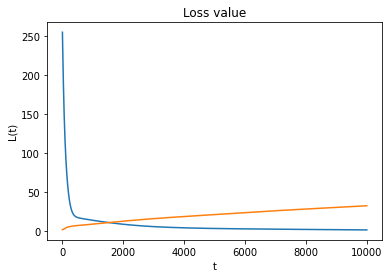

In [65]:
#@title Loss
#import plotly.graph_objs as go
#import plotly

plt.plot(loss_plotter)
plt.plot(weigths_norm_plt)
plt.title(f"Loss value")
plt.xlabel("t")
plt.ylabel(f"L(t)")


# fig = px.line(y=loss_plotter)
# fig.show()
# fig = px.line(y=weigths_norm_plt)
# fig.show()
#px.line(df=weigths_norm_plt], y=['mean_reward','gamma'])

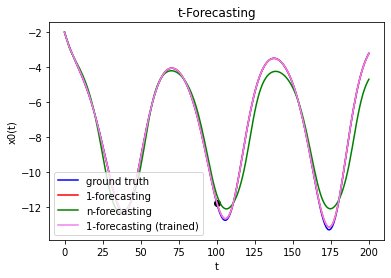

In [66]:
#@title Plot x0 vs t

k=0
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

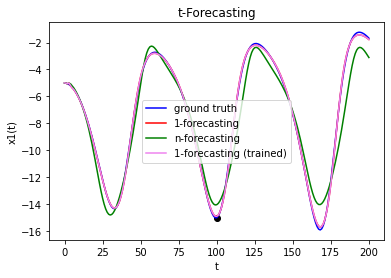

In [67]:
#@title Plot x1 vs t


k=1
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

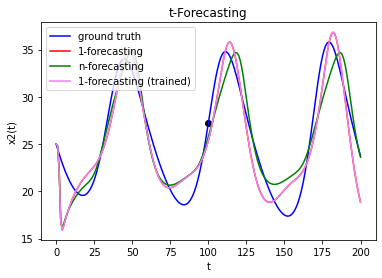

In [68]:
#@title Plot x2 vs t


k=2
plt.title(f"t-Forecasting")
plt.plot(x_sys[:,k], color="blue", label="ground truth")
plt.plot(x_for_1[:,k], color="red", label="1-forecasting")
plt.plot(x_for_n[:,k], color="green",label="n-forecasting")
#if for_hor != "n" and for_hor != 1:
#    plt.plot(x_for_t, color="violet",label=f"{for_hor}-forecasting (trained)")
plt.plot(x_for_t[:,k], color="violet",label=f"{for_hor}-forecasting (trained)")
plt.xlabel("t")
plt.ylabel(f"x{k}(t)")
plt.legend()
plt.scatter(Nt, x_sys[Nt, k], color="black") # training horizon position

plt.show()

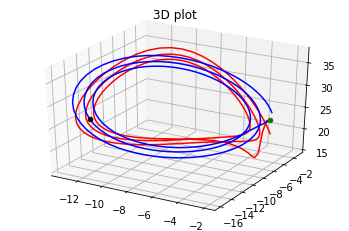

In [69]:
#@title Plot 3D 


ax = plt.axes(projection='3d')
ax.plot3D(x_for_t[:,0].numpy(), x_for_t[:,1].numpy(), x_for_t[:,2].numpy(), 'red', label="gnd")
ax.plot3D(x_sys[:,0].numpy(), x_sys[:,1].numpy(), x_sys[:,2].numpy(), 'blue', label="t-for")
plt.title("3D plot")
ax.scatter(x_sys[0,0],x_sys[0,1],x_sys[0,2], color="green") # initial position
ax.scatter(x_sys[Nt,0],x_sys[Nt,1],x_sys[Nt,2], color="black") # training horizon position

plt.show()

# trace2 = go.Scatter3d(
#     x=x_sys[:,0],
#     y=x_sys[:,1],
#     z=x_sys[:,2],
#     mode='lines',
#     name='lines'
# )
# fig = go.Figure(data=[, weigths_norm_plt])
# plotly.offline.iplot(fig, filename='simple-3d-scatter')
